In [6]:
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# -------------------------------------------------------
# LOAD DATA
# -------------------------------------------------------
DATA_PATH = Path(r"D:\\Project-Vimaan\\Dataset\\output\\base_cmds.jsonl")
texts, intents = [], []

with open(DATA_PATH, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        texts.append(entry["text"])
        intents.append(entry["intent"])

print(f"✅ Loaded {len(texts)} samples")

✅ Loaded 392 samples


In [8]:
# -------------------------------------------------------
# TRAIN/TEST SPLIT
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    texts, intents, test_size=0.2, random_state=42, stratify=intents
)

In [9]:
# -------------------------------------------------------
# TF-IDF VECTORIZE TEXTS
# -------------------------------------------------------
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # include unigrams and bigrams
    max_features=5000,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [10]:
# -------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# -------------------------------------------------------
clf = LogisticRegression(max_iter=200, solver="lbfgs", multi_class="auto")
clf.fit(X_train_tfidf, y_train)

c:\Users\shukl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'auto'



📊 Classification Report:
              precision    recall  f1-score   support

       FLAPS     1.0000    1.0000    1.0000        34
LANDING_GEAR     1.0000    1.0000    1.0000        45

    accuracy                         1.0000        79
   macro avg     1.0000    1.0000    1.0000        79
weighted avg     1.0000    1.0000    1.0000        79



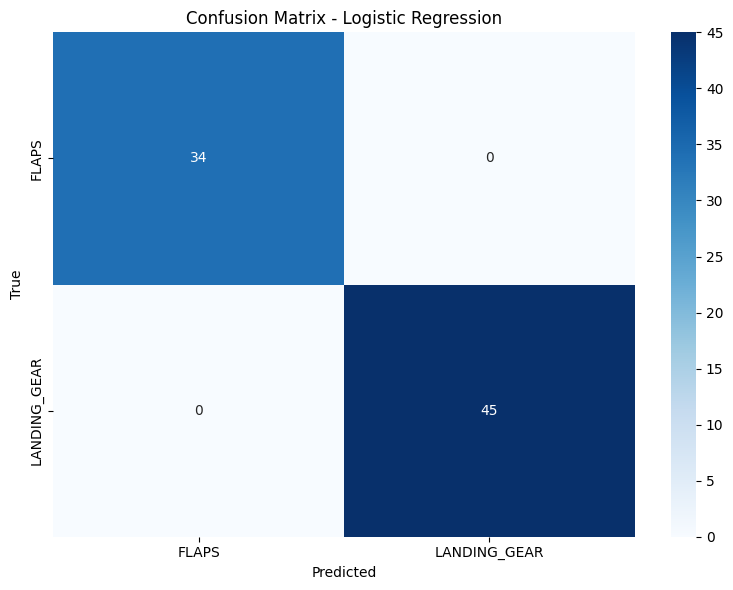

✅ Training complete.


In [11]:
# -------------------------------------------------------
# EVALUATE MODEL
# -------------------------------------------------------
y_pred = clf.predict(X_test_tfidf)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm_df = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("✅ Training complete.")